In [1]:
import os
import time
import pandas as pd
import numpy as np
import seaborn as sns
import random
import itertools
from scipy.stats import pearsonr
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import multiclass
from sklearn import svm
import matplotlib.pyplot as plt

In [2]:
# set path to folder containing clinic watch data
clinicpath = r'//FS2.smpp.local\\RTO\\CIS-PD Study\MJFF Curation\Finalized Dataset'
# set path to folder containing home watch data
homepath = r'//FS2.smpp.local\\RTO\\CIS-PD Study\Patient Record Correlation'
# set path to destination folder
dest = r'//FS2.smpp.local\\RTO\\CIS-PD Study\Watch Features Data'
#---------------------------------------------------------------------------------------------------------

In [3]:
# generate task abbreviation dictionary
ClinicTasks = {
    'Stndg'    : 'Standing',
    'Wlkg'     : 'Walking',
    'WlkgCnt'  : 'Walking while counting',
    'FtnR'     : 'Finger to nose--right hand',
    'FtnL'     : 'Finger to nose--left hand',
    'RamR'     : 'Alternating right hand movements',
    'RamL'     : 'Alternating left hand movements',
    'SitStand' : 'Sit to stand',
    'Drwg'     : 'Drawing on a paper',
    'Typg'     : 'Typing on a computer keyboard',
    'NtsBts'   : 'Assembling nuts and bolts',
    'Drnkg'    : 'Taking a glass of water and drinking',
    'Sheets'   : 'Organizing sheets in a folder',
    'Fldg'     : 'Folding towels',
    'Sitng'    : 'Sitting'
}

In [4]:
# initialize random forest with desired number of trees
cf = RandomForestClassifier(n_estimators = 100)
le = sklearn.preprocessing.LabelEncoder()
grouper = LeaveOneGroupOut()

In [5]:
# visualize layout of features file
# DataFeaturesSEOUL builds from features suggested by Joen et al - contains anomaly destiction based on RMSE threshold
DataFeatures = pd.read_csv(os.path.join(dest, 'Clinic Data', 'DataFeaturesSEOUL.csv'))
DataFeatures.head()

,SubjID,Visit,TaskAbb,Clip,Tremor,Mean_Amp,Avg_Reg,Reg_Std,Peak_Power,Peak_Freq,...,L_Rel_Power,T_Rel_Power,H_Rel_Power,Log_MA,Log_PP,Log_MP,Log_LP,Log_TP,Log_HP,Anomaly
0,1003,0,Sitng,0,1.0,0.009257,75.315790,25.187826,0.002299,6.036217,...,0.573383,0.552220,0.392409,-4.682420,-6.075422,-6.750911,-3.847977,-3.885584,-4.227226,0.0
1,1003,0,Sitng,1,1.0,0.008942,73.710526,24.898645,0.002157,7.424907,...,0.515882,0.605844,0.470547,-4.717051,-6.139228,-6.583013,-4.030221,-3.869477,-4.122203,0.0
2,1003,0,Sitng,2,1.0,0.011091,74.763160,22.535860,0.002379,6.373700,...,0.578165,0.617934,0.406955,-4.501643,-6.040962,-6.174688,-3.865937,-3.799414,-4.217092,0.0
3,1003,0,Sitng,3,1.0,0.009954,77.324326,27.936274,0.001908,6.036217,...,0.576609,0.594498,0.394810,-4.609792,-6.261591,-6.910349,-3.926954,-3.896399,-4.305712,0.0
4,1003,0,Sitng,4,1.0,0.007905,70.525000,21.581228,0.001432,5.030181,...,0.542114,0.591970,0.437347,-4.840227,-6.548516,-7.118376,-4.185095,-4.097116,-4.399844,0.0


In [12]:
# set scaling factor of text components of seaborn plots
sns.set(font_scale = 1.5)

In [13]:
def TrainTestModel(label_type, tasks, newLab, groups, bestFeatIdx):
    '''label_type: \'TaskAbb\' or \'Tremor\' or \'Bradykinesia\' or \'Dyskinesia\' or \'Overall\' 
    tasks: list of tasks to be considered by the model; pass grouped tasks when modelling scores
    newLab: list of new labels for groups of tasks that should be considered together
    groups: list of lists containing tasks to be grouped together'''
    
    # ClinicDataFeatures = reduced features list
    # ClinicDataFeatures2 = expanded features list
    # ClinicDataFeatures3 = only Northwestern site subjects; expanded features list
    # ClinicDataFeaturesX = utlizes overlapping clip windows and an additional metadata column signifying clip number (8:)
    # ClinicDataFeaturesX_FFTscoreFilt = eliminated standing/sitting data whose tremor score doesnt agree with FFT score
    # DataFeaturesSEOUL = anomaly feature present; features generated from paper out of Seoul (feat 5:24)
    DataFeatures = pd.read_csv(os.path.join(dest, 'Clinic Data', 'DataFeaturesSEOUL.csv'))
    # only consider tasks of interest from generalized file of datafeatures
    indices = (x for x in range(len(DataFeatures)) if DataFeatures.TaskAbb.values[x] in tasks)
    DataFeatures = DataFeatures.loc[indices]
    # eliminate any NaN values from datafeatures file to prevent errors
    if type(DataFeatures[label_type].values[-1]) != str:
        DataFeatures = DataFeatures[~np.isnan(DataFeatures[label_type].values)]
    # generate dictionary correlating original scored labels with new desired labels (usually symptomatic/normal)
    if newLab:
        groupDict = {}
        for group, lab in zip(groups, newLab):
            for olab in group:
                groupDict[olab] = lab
        # allows for a group 'Exclude' to remove certain tasks if target labels are task type
        DataFeatures = DataFeatures[DataFeatures[label_type].apply(lambda x: groupDict[x]) != 'Excld']
        
    features_list = list(DataFeatures.columns[5:24])
    
    # necessary if model is to run twice: the second time only considering the most important features from first run
    if bestFeatIdx:
        best_features_list = []
        for idx in bestFeatIdx:
            best_features_list = best_features_list + [features_list[idx]]
        features_list = best_features_list
    
    print('Label = ' + label_type)
    print('--------------------------------------------------')
    print('Tasks Considered:')
    for task in DataFeatures.TaskAbb.unique():
        print('    ' + ClinicTasks[task])
    if newLab:
        print('--------------------------------------------------')
        print('Label Groups:')
        for label in newLab:
            print('    ' + label)

#     # randomly deselect scores of 0 to prevent overfitting
#     if type(DataFeatures[label_type].values[-1]) != str:
#         sympidx = DataFeatures[label_type] != 0
#         zeroidx = DataFeatures[label_type] == 0
#         ZeroDataFeatures = DataFeatures[zeroidx]
#         ZeroDataFeatures = ZeroDataFeatures.sample(1000)
#         DataFeatures = pd.concat([DataFeatures[sympidx], ZeroDataFeatures])
#         print(len(DataFeatures))
    
    # isolate features to input into the model
    X = DataFeatures[features_list].values
    # isolate labels to input to the model
    if newLab:
        # transform original scored labels to new desired labels
        Y = DataFeatures[label_type].apply(lambda x: groupDict[x]).values
    else:
        # use original labels as present
        Y = DataFeatures[label_type].values
    
    # encode the labels for training - necessary if labels are strings (task type or symptomatic/normal)
    le.fit(Y)
    Y = le.transform(Y)
    
#     # test model with training features for overfitting
#     CM = np.zeros(shape = (len(set(Y)), len(set(Y))))
#     FeatInp = np.zeros(shape = (1, 1))
#     TrainFeat = X
#     TrainLab = Y
#     TestFeat = X
#     TestLab = Y
#     cf.fit(TrainFeat, TrainLab)
#     PredLab = cf.predict(TestFeat)
#     TestLab = le.inverse_transform(TestLab)
#     PredLab = le.inverse_transform(PredLab)
#     CM = CM + sklearn.metrics.confusion_matrix(TestLab, PredLab, labels = le.classes_)
#     for i in range(len(CM)):
#         CM[i, :] = (CM[i, :] / sum(CM[i, :])) * 100

    CM = np.zeros(shape = (len(set(Y)), len(set(Y))))
    FeatImp = np.zeros(shape = (1, 1))
    j = True
    k = True
    
    plt.figure(figsize = (12, 10))
    
    # train the model iteratively, validating each time on one isolated subject's data
    for trainInd, testInd in grouper.split(X, Y, groups = DataFeatures.SubjID.values):
        TrainFeat = X[trainInd]
        TrainLab = Y[trainInd]

        TestFeat = X[testInd]
        TestLab = Y[testInd]
        
        # train/fit the random forest model
        cf.fit(TrainFeat, TrainLab)
        
        # if the labels are binary (symptomatic/normal)
        if len(groups) == 2:
            PredLabP = []
            i = True
            treeNum = 0
            trees = []
            AUC = []
            # allow each tree of the model to make predictions on the validaiton group
            # necessary for generating plot of AUC based on number of trees predicting
            for tree in cf.estimators_:
                treePredLab = tree.predict(TestFeat)
                treeNum += 1
                if i:
                    PredLab = treePredLab
                    ProbLab = PredLab
                    i = False
                else:
                    # predicted labels: predictions made by each individual tree of the random forest
                    PredLab = np.vstack([PredLab, treePredLab])
                    # probability labels: averaged value of predictions made by trees considered
                    ProbLab = np.mean(PredLab, axis = 0)
                try:
                    # get the AUC based on the current test labels and probability labels correlated to trees used
                    AUC = AUC + [sklearn.metrics.roc_auc_score(TestLab, ProbLab)]
                    trees = trees + [treeNum]
                except(ValueError):
                    break

            # compile probability labels into a list for use in generating ROC curves later
            if j:
                ProbLabCV = [list(ProbLab)]
                TestLabCV = [list(TestLab)]
                j = False
            else:
                ProbLabCV = ProbLabCV + [list(ProbLab)]
                TestLabCV = TestLabCV + [list(TestLab)]
        
            # for each validation subject, plot the AUC value based on the number of trees used to predict labels
            plt.plot(trees, AUC)
            plt.xlabel('Trees', fontsize = 12)
            plt.ylabel('Area Under ROC Curve', fontsize = 12)
            plt.title('Model Iteration Accuracy', fontsize = 15)
            plt.ylim((0, 1))

        # acquire the feature importance values in this training iteration
        if len(FeatImp) > 1:
            FeatImp = np.vstack((FeatImp, cf.feature_importances_))
        else:
            FeatImp = cf.feature_importances_
        
        # use the full trained model to make predictions on the features of the validation set
        PredLab = cf.predict(TestFeat)

        # reverse the encoding done on the labels earlier to be output
        TestLab = le.inverse_transform(TestLab)
        PredLab = le.inverse_transform(PredLab)
        
        if k:
            TestLabs = list(TestLab)
            PredLabs = list(PredLab)
            testInds = list(testInd)
            k = False
        else:
            TestLabs = TestLabs + list(TestLab)
            PredLabs = PredLabs + list(PredLab)
            testInds = testInds + list(testInd)

        # format the true validaiton labels and the predictions into an array to become a confusion matrix
        CM = CM + sklearn.metrics.confusion_matrix(TestLab, PredLab, labels = le.classes_)
        
    # store the ordered test and prediciton labels into a dataframe to be returned
    TestPred = pd.DataFrame(index = testInds)
    TestPred['TestLabs'] = TestLabs
    TestPred['PredLabs'] = PredLabs
        
    # normalize each row of the confusion matrix to be percentages
    for i in range(len(CM)):
        CM[i, :] = (CM[i, :] / sum(CM[i, :])) * 100
            
    # ROC curve can only be generated if labels are binary (and have a positive label such as symptomatic)
    if len(groups) == 2:
        plt.show()
        
        # plot the receiver operater curve for each validation subject
        plt.figure(figsize = (12, 10))
        # PL = probability labels generated from averaging predictions of each tree
        # TL = true labels from validation set
        for PL, TL in zip(ProbLabCV, TestLabCV):
            if len(set(TL)) == 1:
                continue
            fpr, tpr, thresholds = sklearn.metrics.roc_curve(TL, PL)
            plt.plot(fpr, tpr)
            plt.xlabel('False Positive Rate', fontsize = 12)
            plt.ylabel('True Positive Rate', fontsize = 12)
            plt.title('Receiver Operating Characteristic Curve', fontsize = 15)
        plt.show()
    
    if len(groups) == 2:
        plt.figure(figsize = (6, 5))
#         sns.set(font_scale = 8)
    else:
        plt.figure(figsize = (12, 10))
    # plot the confusion matrix that has been compiled from true and predicted labels
    sns.heatmap(CM, xticklabels = le.classes_, yticklabels = le.classes_, annot = True)
    plt.xlabel('Predicted', fontsize = 16)
    plt.ylabel('Test', fontsize = 16)
    
    # plot a barplot of the feature importances
    plt.figure(figsize = (16, 12))
    sns.barplot(data = pd.DataFrame(FeatImp, columns = features_list))
    plt.xticks(rotation = 90)
    plt.title('Feature Importances', fontsize = 15)
    
    print(len(DataFeatures))
    print(len(TestPred))
    
    return cf, FeatImp, TestPred, DataFeatures

Label = Tremor
--------------------------------------------------
Tasks Considered:
    Sitting
    Standing
--------------------------------------------------
Label Groups:
    Normal
    Symptomatic


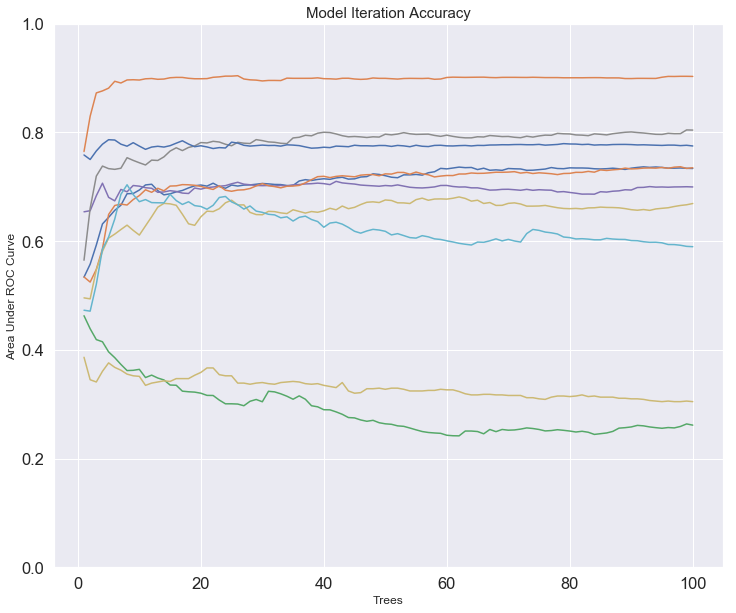

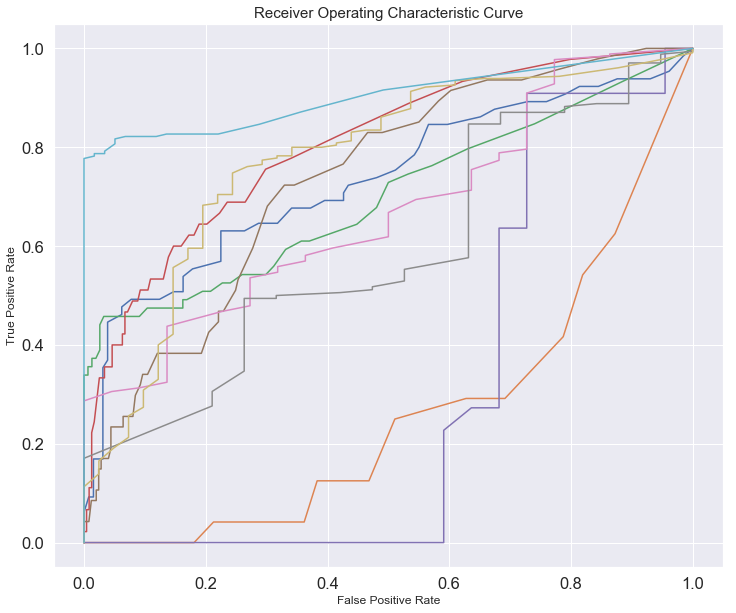

5438
5438


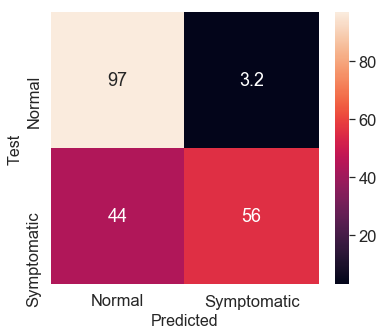

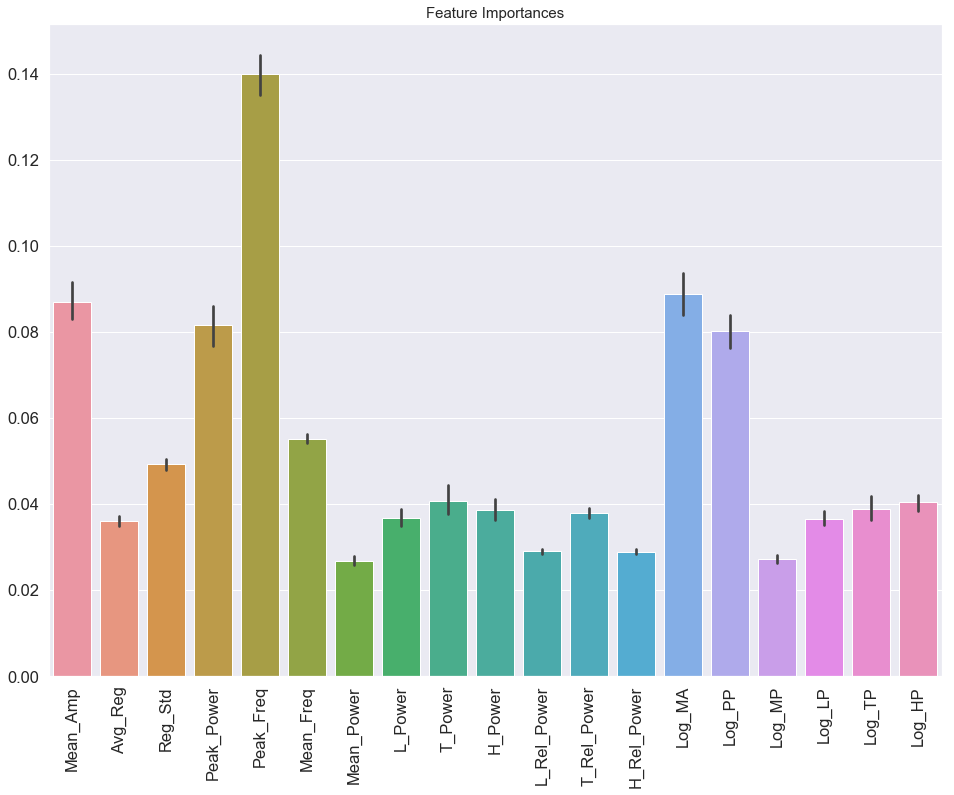

In [14]:
### TASKS
# tasks = ['Drnkg', 'Drwg', 'Fldg', 'FtnL', 'FtnR', 'NtsBts', 'RamL', 'RamR', 'Sheets', 'Sitng', 'SitStand', 'Stndg', 'Typg', 'Wlkg', 'WlkgCnt']
# tasks = ['RamL', 'RamR']
# tasks = ['FtnL', 'FtnR']
tasks = ['Sitng', 'Stndg']
# tasks = ['Wlkg', 'WlkgCnt']
# tasks = ['Fldg', 'Sheets', 'Drnkg', 'NtsBts', 'Typg', 'Drwg']

# tasks = ['Sitng']

### NEWLAB, GROUPS
# newLab, groups = ['Excld', 'Ram', 'Ftn', 'Rest', 'Wlkg', 'FinMot'], [['SitStand'], ['RamL', 'RamR'], ['FtnL', 'FtnR'], ['Sitng', 'Stndg', 'Drwg'], ['Wlkg', 'WlkgCnt'], ['Fldg', 'Sheets', 'Drnkg', 'NtsBts', 'Typg']]
newLab, groups = ['Normal', 'Symptomatic'], [[float(0)], [float(1), float(2), float(3), float(4)]]
# newLab, groups = [], []

### LABEL_TYPE
# label_type = 'TaskAbb'
label_type = 'Tremor'
# label_type = 'Bradykinesia'
# label_type = 'Dyskinesia'
# label_type = 'Overall'

bestFeatIdx = []

## RERUN MODEL WITH ONLY N MOST IMPORTANT FEATURES
# model, FeatImp = TrainTestModel(label_type, tasks, newLab, groups, bestFeatIdx)
# AvgFeatImp = np.mean(FeatImp, axis = 0)
# bestFeatIdx = list(AvgFeatImp.argsort()[-10:][::-1])

model, FeatImp, TestPred, DataFeatures = TrainTestModel(label_type, tasks, newLab, groups, bestFeatIdx)

In [9]:
# print a list of the saved 5-second segment clips that the model returned to be true positives
# can be used for further/deeper analysis of specific clips
TPind = (TestPred.TestLabs == 'Symp') & (TestPred.PredLabs == 'Symp')
TPDataFeatures = DataFeatures.reset_index()[TPind]

TPClipFiles = []
for clip in TPDataFeatures.iterrows():
    File = str(int(clip[1]['SubjID'])) + '_' + str(clip[1]['Visit']) + '_' + clip[1]['TaskAbb'] + '_' + str(clip[1]['Clip'])
    TPClipFiles = TPClipFiles + [File]
TPClipFiles

['1003_0_Sitng_0',
 '1003_0_Sitng_1',
 '1003_0_Sitng_2',
 '1003_0_Sitng_3',
 '1003_0_Sitng_4',
 '1003_0_Sitng_5',
 '1003_0_Sitng_6',
 '1003_0_Sitng_7',
 '1003_0_Sitng_8',
 '1003_0_Sitng_9',
 '1003_0_Sitng_10',
 '1003_0_Sitng_11',
 '1003_0_Sitng_12',
 '1003_0_Sitng_13',
 '1003_4_Sitng_4',
 '1019_0_Sitng_10',
 '1019_0_Sitng_11',
 '1019_1_Sitng_6',
 '1019_1_Sitng_7',
 '1019_1_Sitng_9',
 '1019_1_Sitng_10',
 '1020_6_Sitng_8',
 '1020_6_Sitng_9',
 '1020_6_Sitng_10',
 '1020_6_Sitng_11',
 '1029_0_Sitng_2',
 '1029_0_Sitng_3',
 '1029_0_Sitng_4',
 '1029_0_Sitng_12',
 '1046_0_Sitng_0',
 '1046_0_Sitng_7',
 '1046_0_Sitng_8',
 '1046_0_Sitng_9',
 '1046_0_Sitng_10',
 '1046_1_Sitng_4',
 '1046_1_Sitng_5',
 '1046_1_Sitng_6',
 '1046_1_Sitng_7',
 '1046_2_Sitng_4',
 '1046_2_Sitng_5',
 '1046_3_Sitng_6',
 '1046_3_Sitng_7',
 '1046_3_Sitng_8',
 '1046_3_Sitng_9',
 '1046_4_Sitng_1',
 '1046_4_Sitng_2',
 '1046_4_Sitng_3',
 '1046_4_Sitng_6',
 '1046_4_Sitng_7',
 '1046_4_Sitng_8',
 '1046_4_Sitng_9',
 '1048_0_Sitng_0',
 

In [10]:
# print a list of the saved 5-second segment clip files that the model returned to be false negatives
FNind = (TestPred.TestLabs == 'Symp') & (TestPred.PredLabs == 'NoSymp')
FNDataFeatures = DataFeatures.reset_index()[FNind]

FNClipFiles = []
for clip in FNDataFeatures.iterrows():
    File = str(int(clip[1]['SubjID'])) + '_' + str(clip[1]['Visit']) + '_' + clip[1]['TaskAbb'] + '_' + str(clip[1]['Clip'])
    FNClipFiles = FNClipFiles + [File]
FNClipFiles

['1003_4_Sitng_0',
 '1003_4_Sitng_1',
 '1003_4_Sitng_2',
 '1003_4_Sitng_3',
 '1003_4_Sitng_5',
 '1003_4_Sitng_6',
 '1005_2_Sitng_0',
 '1005_2_Sitng_1',
 '1005_2_Sitng_2',
 '1005_3_Sitng_0',
 '1005_3_Sitng_1',
 '1005_3_Sitng_2',
 '1005_3_Sitng_3',
 '1005_3_Sitng_4',
 '1005_3_Sitng_5',
 '1005_3_Sitng_6',
 '1005_3_Sitng_7',
 '1005_3_Sitng_8',
 '1005_3_Sitng_9',
 '1019_0_Sitng_0',
 '1019_0_Sitng_1',
 '1019_0_Sitng_2',
 '1019_0_Sitng_3',
 '1019_0_Sitng_4',
 '1019_0_Sitng_5',
 '1019_0_Sitng_6',
 '1019_0_Sitng_7',
 '1019_0_Sitng_8',
 '1019_0_Sitng_9',
 '1019_0_Sitng_12',
 '1019_0_Sitng_13',
 '1019_1_Sitng_0',
 '1019_1_Sitng_1',
 '1019_1_Sitng_2',
 '1019_1_Sitng_3',
 '1019_1_Sitng_4',
 '1019_1_Sitng_5',
 '1019_1_Sitng_8',
 '1020_6_Sitng_0',
 '1020_6_Sitng_1',
 '1020_6_Sitng_2',
 '1020_6_Sitng_3',
 '1020_6_Sitng_4',
 '1020_6_Sitng_5',
 '1020_6_Sitng_6',
 '1020_6_Sitng_7',
 '1020_6_Sitng_12',
 '1029_0_Sitng_0',
 '1029_0_Sitng_1',
 '1029_0_Sitng_5',
 '1029_0_Sitng_6',
 '1029_0_Sitng_7',
 '1029_0_

1009_1_FtnL_3
['1005_3_FtnL_8', '1005_3_FtnL_9', '1009_1_FtnL_0', '1009_1_FtnL_1', '1009_1_FtnL_2', '1009_1_FtnL_3', '1009_1_FtnL_4', '1009_1_FtnL_5', '1009_1_FtnL_6', '1009_1_FtnL_7']


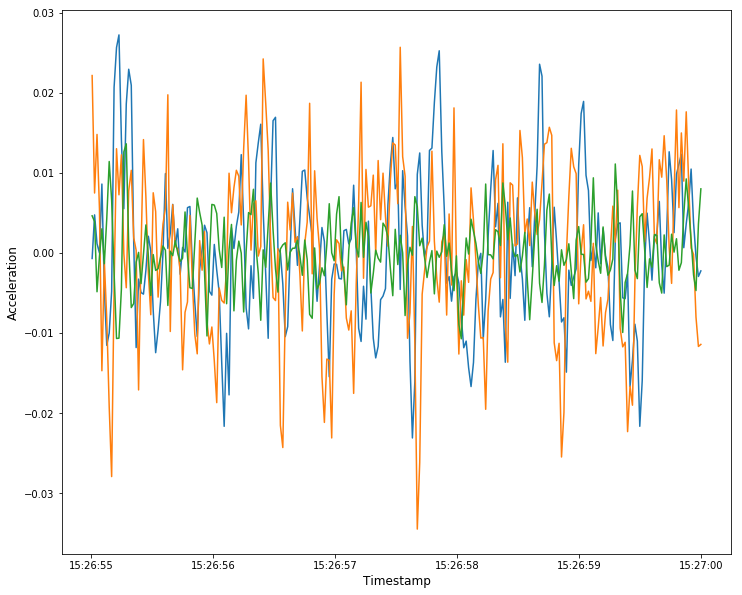

In [25]:
# plot the saved clip acceleration file from the list of either true positives or false negatives for visualization
TP = False
FN = True
# select the index of the clip to be visualized
clip = 66

if TP:
    Clip = (pd.read_csv(os.path.join(dest, 'Clinic Data', 'Feature Clips', TPClipFiles[clip] + '.csv'), 
                        parse_dates = ['Timestamp']) [['Timestamp', 'X', 'Y', 'Z']])
elif FN:
    Clip = (pd.read_csv(os.path.join(dest, 'Clinic Data', 'Feature Clips', FNClipFiles[clip] + '.csv'), 
                        parse_dates = ['Timestamp']) [['Timestamp', 'X', 'Y', 'Z']])
plt.figure(figsize = (12, 10))
plt.plot(Clip.Timestamp, Clip.X, Clip.Timestamp, Clip.Y, Clip.Timestamp, Clip.Z)
plt.xlabel('Timestamp', fontsize = 12)
plt.ylabel('Acceleration', fontsize = 12)
# print the names of the surrounding clips to the clip of interest to see if clips surronding are also TP/FN
if TP:
    print(TPClipFiles[clip])
    print(TPClipFiles[clip - 5:clip + 5])
elif FN:
    print(FNClipFiles[clip])
    print(FNClipFiles[clip - 5:clip + 5])

1009_1_FtnL


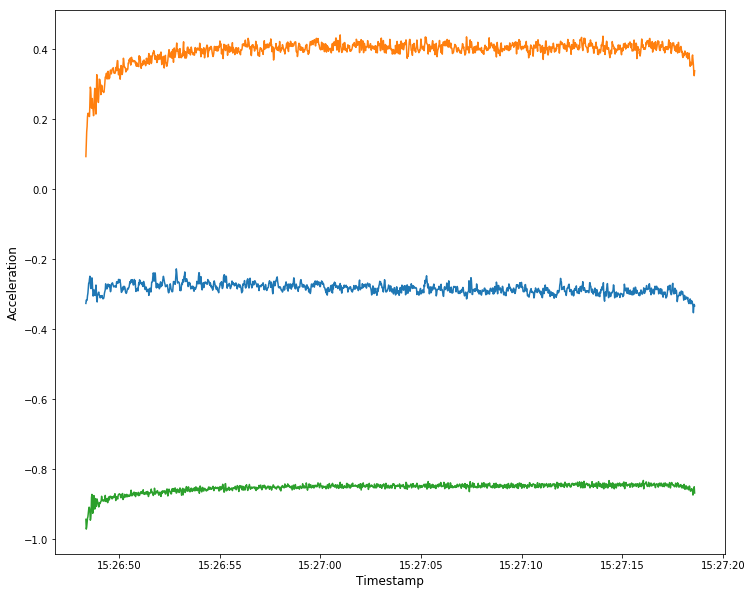

In [26]:
# visualize a specific recording in full
task = '1009_1_FtnL'
Task = (pd.read_csv(os.path.join(clinicpath, 'TaskAcc', task + '.csv'), parse_dates = ['timestamp'])
        [['timestamp', 'x', 'y', 'z']])
plt.figure(figsize = (12, 10))
plt.plot(Task.timestamp, Task.x, Task.timestamp, Task.y, Task.timestamp, Task.z)
plt.xlabel('Timestamp', fontsize = 12)
plt.ylabel('Acceleration', fontsize = 12)
print(task)

In [57]:
# visualize a specific portion or filtered amount of the datafeatures file
Sitting = DataFeatures[(DataFeatures.TaskAbb == 'Sitng') & (DataFeatures.Tremor == 0) & (DataFeatures.Dyskinesia == 0)]
Sitting[:50]

,SubjID,Visit,TaskAbb,Clip,Tremor,Bradykinesia,Dyskinesia,Overall,RMSX,RMSY,...,Sen_X,Sen_Y,Sen_Z,RMS_mag,range_mag,mean_mag,var_mag,skew_mag,kurt_mag,Sen_mag
1046,1004.0,0,Sitng,0,0.0,NaN,0.0,NaN,0.000298,0.000590,...,1.930596,1.733550,1.789110,1.245778e-05,0.001079,0.000120,0.000134,2.914353,13.709634,0.022691
1047,1004.0,0,Sitng,1,0.0,NaN,0.0,NaN,0.000248,0.000406,...,1.995224,1.894414,1.857899,7.114081e-06,0.000474,0.000078,0.000081,2.063628,5.219839,0.017518
1048,1004.0,0,Sitng,2,0.0,NaN,0.0,NaN,0.000192,0.000279,...,2.017281,1.774707,2.039053,3.572280e-06,0.000259,0.000043,0.000036,1.647310,4.548750,0.025485
1049,1004.0,0,Sitng,3,0.0,NaN,0.0,NaN,0.000178,0.000256,...,1.963005,1.910192,1.653890,3.213812e-06,0.000174,0.000039,0.000033,1.296266,1.655585,0.020922
1050,1004.0,0,Sitng,4,0.0,NaN,0.0,NaN,0.000166,0.000240,...,1.981001,1.923096,1.649789,2.864570e-06,0.000175,0.000034,0.000030,1.809649,4.449742,0.021040
1051,1004.0,0,Sitng,5,0.0,NaN,0.0,NaN,0.000165,0.000275,...,1.928705,1.938974,2.017199,3.126544e-06,0.000252,0.000036,0.000034,2.278371,7.952722,0.017599
1052,1004.0,0,Sitng,6,0.0,NaN,0.0,NaN,0.000174,0.000305,...,1.856764,1.843536,1.912712,3.494829e-06,0.000252,0.000040,0.000038,1.935939,4.787440,0.018933
1053,1004.0,0,Sitng,7,0.0,NaN,0.0,NaN,0.000175,0.000273,...,2.041701,2.056021,1.935350,2.961927e-06,0.000171,0.000034,0.000032,1.896687,3.923138,0.018898
1054,1004.0,0,Sitng,8,0.0,NaN,0.0,NaN,0.000171,0.000253,...,2.095273,1.803267,1.766070,2.739732e-06,0.000237,0.000031,0.000030,2.410645,9.667494,0.017555
1055,1004.0,0,Sitng,9,0.0,NaN,0.0,NaN,0.000173,0.000246,...,1.984826,1.837972,1.645156,2.819183e-06,0.000237,0.000032,0.000031,2.685025,11.329412,0.015953
